In [2]:
import os
from PIL import Image
import time
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
mpl.rcParams['figure.figsize'] = [10, 10]

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [14]:
def dice_loss(pred, target):
  overlap = torch.mul(pred, target).sum()
  area = target.sum() + pred.sum()
  return 2 * overlap / area

tensor(1.)

## Unet architecture

In [6]:
a = torch.arange(9).view(3,3 )
if 30 in a:
  print('si esta')

In [3]:
def crop_skip_connection(output, starting_depth, total_depth):
  # starting_depth starts from 1
  original_shape = output.shape[-1]
  final_shape = original_shape
  depth = total_depth - starting_depth
  # encoder pathway
  for i in range(depth):
    final_shape /= 2
    final_shape -= 4
  # decoder pathway
  for i in range(depth):
    final_shape *= 2
    if i != depth-1:
      final_shape -= 4
  margin = (original_shape - final_shape)/2 
  start = int(margin)
  end = int(original_shape - margin)
  output = output[..., start:end, start:end]
  return output


def conv3d(in_channels, out_channels, stride=1, 
            padding=0, bias=True, groups=1):    
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        bias=bias,
        groups=groups)

def upconv2d(in_channels, out_channels, mode='transpose'):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=2,
        stride=2)


def conv1d(in_channels, out_channels, groups=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=1,
        groups=groups,
        stride=1)
        
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super(Encoder, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3d(self.in_channels, self.out_channels)
        ## !TODO: adding batchnorm
        self.conv2 = conv3d(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x  # for skip connection
        if self.pooling:
            x = self.pool(x)
        return x, before_pool

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 merge_mode='concat', up_mode='transpose'):
        super(Decoder, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2d(self.in_channels, self.out_channels, 
            mode=self.up_mode)

        self.conv1 = conv3d(2*self.out_channels, self.out_channels)

        self.conv2 = conv3d(self.out_channels, self.out_channels)


    def forward(self, from_down, from_up):
        from_up = self.upconv(from_up)

        x = torch.cat((from_up, from_down), 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

class UNet(nn.Module):

    def __init__(self, num_classes, in_channels=3, depth=5, 
                 start_filts=64, up_mode='transpose', 
                 merge_mode='concat'):

        super(UNet, self).__init__()

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = Encoder(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = Decoder(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1d(outs, self.num_classes)

        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            init.xavier_normal(m.weight)
            init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)


    def forward(self, x):
        encoder_outs = []
         
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            cropped = crop_skip_connection(before_pool, i+1, self.depth)
            encoder_outs.append(cropped)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)
        
        x = self.conv_final(x)
        return x

# Helper Functions

In [4]:
### ----- Cleaning data -------
def remove_white_area(image):
    '''
      output is (2560, 2560, 3) for images and (2560, 2560) for labels
    '''
    size = 2560
    ### images
    if len(image.shape) == 3:
      if image.shape[0] >= size:
        x = (image.shape[0]-size)//2
        y = image.shape[1]-(image.shape[1]-size)//2

        if ((size-image.shape[0])%2 == 1):
          return image[x:y-1, x:y-1, :]
        return image[x:y, x:y, :]
      
      ## padding (add more white area)
      x = (size-image.shape[0])//2
      y = (size-image.shape[1])//2
      
      if ((size-image.shape[0])%2 == 1):
        return np.pad(image, ((x, x+1), (y, y+1), (0, 0)), constant_values=(245, 245))
      return np.pad(image, ((x, x), (y, y), (0, 0)), constant_values=(245, 245))
      
    ### labels
    if len(image.shape) == 2:
      if image.shape[0] >= size:
        x = (image.shape[0]-size)//2
        y = image.shape[1]-(image.shape[1]-size)//2

        if ((size-image.shape[0])%2 == 1):
          return image[x:y-1, x:y-1]
        return image[x:y, x:y]

      ## padding (add more white area)
      x = (size-image.shape[0])//2
      y = (size-image.shape[1])//2

      if ((size-image.shape[0])%2 == 1):
        return np.pad(image, ((x, x+1), (y, y+1)), constant_values=(0, 0))
      return np.pad(image, ((x, x), (y, y)), constant_values=(0, 0))

####--- Patching for original Unet ------# 
def input_compatible(output_shape, depth):
# Given an output shape of a contracting U-net, calculate the necessary input shape to 
# produce it.
  # Going back through decoder:
  input_shape = float(output_shape)
  for _ in range(depth-1):
    input_shape += 4 # restore borders lost to convolution
    input_shape /= 2 # undo Upampling
    if not input_shape.is_integer():  
      return False 
  # Going back through encoder:
  for i in range(depth):
    input_shape += 4 # restore borders lost to convolution
    if i == depth-1:
      continue
    input_shape *= 2 # undo Downsampling
    if not input_shape.is_integer():  
      return False 
  return input_shape

def Unet_padding(output_shape, depth):
# Returns padding necesary for input on each border for a desired output.
# Output shape should be a scalar (width or height)
  input_shape = input_compatible(output_shape, depth)
  padding =  (input_shape - output_shape) / 2
  return padding

def cut_img(img, label, factor=4, contractingUnet=True, depth=5):
  # Img shape should be (3, height, width), each patch will have heigt = original_height / factor 
  # Label shape should be (height, width)
  # so it produces factor^2 patches
  # If the image height or width is not divisible by the factor, padding with 0 is performed on each side
  # until it is or rows and columns get deleted (preferred).
  assert img.shape[0] == 3, f'img shape must be (3,h,w) but was given {img.shape}'
  assert label.shape[0] == label.shape[1], f'label shape must be (h,w) but was given {label.shape}'

  # Or remove rows and columns from the image
  data = torch.cat([img,label[None, :, :]]) # Should have dim (4, height, width) with 4th channel being the labels
  height = img.shape[1]
  i = 0
  while height % factor != 0:
    data = data[:, :-1, :-1] if i%2==0 else data[:, 1:, 1:] # Remove alternating between top-left and bottom-right
    height = data.shape[1]
    i += 1

  output_shape = height / factor
  img_patches = []
  label_patches = []

  if contractingUnet:
    # Check if tiling is compatible with some Unet input, if not reduce output shape
    while not input_compatible(output_shape, depth):
      output_shape -= 1
    # Reduce image to adapt to new tiling shape
    new_data_shape = output_shape * factor
    i = 0
    while data.shape[-1] != new_data_shape:
      data = data[:, :-1, :-1] if i%2==0 else data[:, 1:, 1:] # Remove alternating between top-left and bottom-right
      i += 1
    # Separate data and labels again, transformation for input_shape is only performed on image data
    labels = data[3]
    img = data[:3]
    # Calculate the padding needed for input to Unet
    padding =  Unet_padding(output_shape, depth) 
    # Cut the image
    for i in range(factor):
      for j in range(factor):
        # Image patch 
        # Location in image:
        h = i * output_shape
        w = j * output_shape
        padding = int(padding)
        # Check if image needs reflection
        top_ref = True if i == 0 else False
        bot_ref = True if i == factor - 1 else False
        left_ref = True if j == 0 else False
        right_ref = True if j == factor - 1 else False
        # Cases
        hl = int(np.maximum(h - padding, 0))
        hr = int(h + padding + output_shape)
        wl = int(np.maximum(w - padding, 0))
        wr = int(w + padding + output_shape)
        patch = img[:, hl:hr, wl:wr]
        if left_ref:
          padder = nn.ReflectionPad2d((padding,0,0,0))
          patch = padder(patch)
        if right_ref:
          padder = nn.ReflectionPad2d((0,padding,0,0))
          patch = padder(patch)
        if top_ref:
          padder = nn.ReflectionPad2d((0,0,padding,0))
          patch = padder(patch)
        if bot_ref:
          padder = nn.ReflectionPad2d((0,0,0,padding))
          patch = padder(patch)
        img_patches.append(patch)
      # Label patch
        hl = int(h)
        hr = int(h + output_shape)
        wl = int(w)
        wr = int(w + output_shape)
        label_patch = labels[hl:hr, wl:wr]
        label_patches.append(label_patch)
  else:
    for i in range(factor):
      for j in range(factor):
        hl = int(i * output_shape)
        wl = int(j * output_shape)
        hr = int(hl + output_shape)
        wr = int(wl + output_shape)
        patch = data[:, hl:hr, wl:wr]
        patches.append(patch)
  img_patches = torch.stack(img_patches)
  label_patches = torch.stack(label_patches)
  return img_patches, label_patches


### ----- Image decoding ----
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def image_recon(patches):
  # patches is a tensor of shape (#ofpatches, patch_size, patch_size)
  # Assumes #ofpatches is a perfect square
  shape = patches.shape
  per_row = math.isqrt(shape[0])
  patch_size = shape[1]
  recon = patches.contiguous().view(per_row, per_row, patch_size, patch_size)
  recon = recon.permute(0,2,1,3).reshape(per_row*patch_size, per_row*patch_size)
  return recon

def unnormalize(img):
  # expected img dim: (3, height, width)
  # Returns (3, height, width) unnormalized
  mean_tensor = torch.tensor([0.8291, 0.8037, 0.8217])
  std_tensor = torch.tensor([0.1692, 0.1958, 0.1842])
  assert img.shape[0] == 3, f"Img shape should be (3, height, width), got {img.shape}"
  img = img * std_tensor[:, None, None] + mean_tensor[:, None, None]
  return img

# Dice coefficient
def dice_coeff(pred, target):
  target_area = target.sum()
  pred_area = pred.sum()
  total_area = target_area + pred_area 
  if pred_area == 0:
    overlap = 0
  else:
    overlap = torch.bincount((pred+target).flatten())[2]
  dice = 2 * overlap / total_area
  return dice

# Utility for gpu 
def cuda_mem(x='..'): # Function to check memory in gpu 
  print(f'{torch.cuda.memory_allocated() * 9.3e-10 :.2f} Gb used after: {x}')

######------ Precomputed Parameters-----
# Calculate weights for cross entropy ------- #
# Following this post: https://discuss.pytorch.org/t/choosing-weights-for-weighted-cross-entropy-loss/102240/2
# total = 0
# targets = 0
# for (img, label) in dataset:
#   targets += label.sum()
#   total += label.numel()
# weight_target = total / targets
# weight_bkg = total / (total - targets)
# weight_tensor = torch.tensor([weight_bkg, weight_target]) # I think, since class 0 is background, 1 is target (?)

### ---- Data Normalization ------- #
# This has to be run after changing KaggleDataset to return images transformed by torchvision.transforms.ToTensor
# so the mean and std in the range [0,1] is calculated

# Calculate channel mean across whole dataset
# total_pixels = 0
# total_chan1 = 0
# total_chan2 = 0
# total_chan3 = 0
# for img, label in dataset:
#   img = img.permute(1,2,0)
#   total_pixels += label.shape[0] * label.shape[1]
#   total_chan1 += img[:,:,0].sum()
#   total_chan2 += img[:,:,1].sum()
#   total_chan3 += img[:,:,2].sum()
# mean_chan1 = total_chan1 / total_pixels
# mean_chan2 = total_chan2 / total_pixels
# mean_chan3 = total_chan3 / total_pixels
# mean_tensor = torch.tensor([mean_chan1, mean_chan2, mean_chan3])

# Calculate channel std across whole dataset 
# sqrd_error1 = 0
# sqrd_error2 = 0
# sqrd_error3 = 0
# for img, label in dataset:
#   img = img.permute(1,2,0)
#   sqrd_error1 += (img[:,:,0] - mean_chan1).pow(2).sum()
#   sqrd_error2 += (img[:,:,1] - mean_chan2).pow(2).sum()
#   sqrd_error3 += (img[:,:,2] - mean_chan3).pow(2).sum()
# std1 = torch.sqrt(sqrd_error1 / total_pixels)
# std2 = torch.sqrt(sqrd_error2 / total_pixels)
# std3 = torch.sqrt(sqrd_error3 / total_pixels)
# std_tensor = torch.tensor([std1, std2, std3])

# Mean and Std across whole dataset for original data
# mean_tensor = torch.tensor([0.8291, 0.8037, 0.8217])
# std_tensor = torch.tensor([0.1692, 0.1958, 0.1842])

# Mean and Std across whole dataset for original augmented data
mean_tensor = torch.tensor([0.8142, 0.7921, 0.8040])
std_tensor = torch.tensor([0.1712, 0.1966, 0.1855])

# Transformation
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                              mean = mean_tensor,
                                              std = std_tensor)])

In [86]:
# Create nice visualization of augmented data
# im_num = 43 * 3 # Cool image, 43, 29
# img = dataset[im_num][0]
# label = dataset[im_num][1]
# impat, labpat = cut_img(img.permute(2,0,1), label, contractingUnet=True, depth=6) 
# print(labpat.shape)
# print(impat.shape)

# # Padding to center the labels and create border to visualize tiling patch
# pad = (impat.shape[-1] - labpat.shape[-1])/2
# pad = int(pad)
# rect_shape = labpat.shape[-1]
# padder = nn.ConstantPad2d(pad, 0)
# labpat = padder(labpat)

# # Plot
# fig, ax = plt.subplots(4,4)
# ax = ax.flatten()
# for i in range(16):
#   im = ax[i].imshow(unnormalize(impat[i]).permute(1,2,0))
#   cm = im.get_cmap()
#   cm.set_under('k', alpha=0)
#   ax[i].imshow(labpat[i], alpha=0.3, cmap=cm, clim=[0.9, 1])
#   rect = patches.Rectangle((pad, pad), rect_shape, rect_shape, linewidth=1, edgecolor='r', facecolor='none')
#   ax[i].add_patch(rect)

## Data set

In [5]:
class KaggleDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.labels = pd.read_csv(label_dir)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Labels
        labels = self.labels.iloc[index]
        id = str(labels['id'])
        # Image
        img_path = os.path.join(self.image_dir, id + ".jpeg")
        image = np.array(Image.open(img_path).convert("RGB"))
        # rle
        rle = labels['rle']
        decoded_rle = rle_decode(rle, shape = image.shape[:2])

        return transform(remove_white_area(image)).permute(1,2,0), torch.tensor(remove_white_area(decoded_rle))

class PatchDS(Dataset):
    # Class used in training loop to load the patches in a batch 
    def __init__(self, images, labels):
        self.images= images
        self.labels = labels

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
      return self.images[index], self.labels[index]

IMAGES_DIRECTORY = "augmented_data/images/"
TRAIN_LABEL_DIRECTORY = "augmented_data/augmented_labels.csv"

dataset = KaggleDataset(
    image_dir=IMAGES_DIRECTORY,
    label_dir=TRAIN_LABEL_DIRECTORY,
)

# Metamodel

In [6]:
class metamodel():
  def __init__(self, model, depth):
    self.model = model
    self.depth = depth

  def predict(self, image, label):
    image = image.permute(2,0,1)
    image_patches, label_patches = cut_img(image, label, depth=self.depth)
    img_pred = []
    for i, patch in enumerate(DataLoader(image_patches)):
      patch = patch.float()
      pred = model(patch).squeeze().softmax(0).argmax(0)
      pred = pred.detach()
      img_pred.append(pred)
    img_pred = torch.stack(img_pred)
    img_pred = image_recon(img_pred)
    label = [label_patches[i] for i in range(label_patches.shape[0])]
    label = torch.stack(label)
    label = image_recon(label)
    return img_pred.type(torch.long), label.type(torch.long)

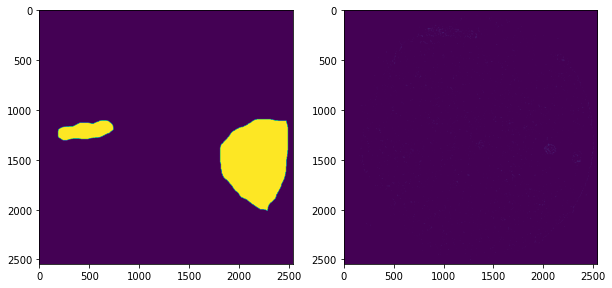

In [89]:
device = 'cpu'
depth = 4
model = UNet(num_classes=2, depth=depth, merge_mode='concat').to(device)
meta = metamodel(model, depth)
img1, label = dataset[834j]
pred, label = meta.predict(img1, label)

fig, ax = plt.subplots(1,2)
ax = ax.flatten()
ax[0].imshow(label)
ax[1].imshow(pred)

In [91]:
pred.sum()

tensor(4400)

# Training

In [ ]:
# Training the Unet

# Train / Test split
total_elements = np.arange(len(dataset))
originals = [i for i in total_elements if i%3==0]
test_elements = np.random.choice(originals, 15)
removed = [[i, i+1, i+2] for i in test_elements]
removed = [item for sublst in removed for item in sublst]
total_elements = np.delete(total_elements, removed)
train_elements = total_elements
np.random.shuffle(train_elements)

# Training parames
device = "cuda" if torch.cuda.is_available() else "cpu"
weight_tensor = torch.tensor([0.1325, 0.8675])
learning_rate = 0.001
nummer_of_epoch = 3
depth = 6

model = UNet(num_classes=2, depth=depth, merge_mode='concat').to(device)
criterion = nn.CrossEntropyLoss(weight=weight_tensor.to(device)).to(device) # With weights
# criterion = nn.CrossEntropyLoss().to(device) # Without weights
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

number_of_epoch = 4
factor = 4 # Factor to divide the image: factor -> factor**2 patches per image
patch_batchsize = 2

last_elements = int( 50 * factor / patch_batchsize) # How many elements to average over to get mean loss every 50 imgs

loss_plot = []
epoch_plot = []
loss_in_epoch = {i:[] for i in range(number_of_epoch)} # To save loss within epoch, every 50 images
dice_results = []

for epoch in range(number_of_epoch):
    loss_epoch = []
    for img_counter, element_index in enumerate(train_elements):
        start_inner = time.time()
        image , label = dataset[element_index]
        image = image.permute(2,0,1)
        image_patches, label_patches = cut_img(image, label, depth=depth)
        patch_dataset = PatchDS(image_patches, label_patches)
        patch_loader = DataLoader(patch_dataset, batch_size=patch_batchsize, shuffle=True)
        for patch_counter, (patches, labels) in enumerate(patch_loader):
            # Forward
            outputs = model(patches.float().to(device))
            labels = labels.long().to(device)
            #cuda_mem('output, labels')
            loss = criterion(outputs, labels)
            #cuda_mem('loss')
            # Backwards
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Gather data
            loss_epoch.append(loss.item())
        if img_counter % 50 == 0:
            if img_counter == 0:
                avg_loss = loss.item()
            else:
                avg_loss = np.array(loss_epoch[-last_elements:]).mean()
            loss_in_epoch[epoch].append(avg_loss)
            print(f'Epoch {epoch}: image: {img_counter} / {len(train_elements)}, loss (last 50) = {avg_loss :.2f}')
        break

    end_inner = time.time()
    delta_inner = (end_inner - start_inner) / 60
    start_outer = time.time()

    loss_epoch = np.array(loss_epoch)
    loss_plot.append(sum(loss_epoch) / len(loss_epoch))
    epoch_plot.append(epoch)
    # Calculate dice coefficient
    dice_in_epoch = []
    for test_idx in test_elements:
        img, label = dataset[test_idx]
        meta = metamodel(model, depth)
        pred, target = meta.predict(img, label)
        dice_in_epoch.append(dice_coeff(pred, target))
    dice_results.append(np.array(dice_in_epoch).mean())

    end_outer = time.time()
    delta_outer = (start_outer - end_outer) / 60
    total_time = delta_inner*number_of_epoch*len(train_elements) + delta_outer*number_of_epoch 

    print(f'Expected time: {total_time} mins ({total_time/60} hrs)')
    print(f'Epoch:{epoch}:  Dice coeff {dice_results[epoch]}')
    print(f"{'-'*20}Finished Epoch {epoch} {'-'*20}")
    break



# Testing and new functions

In [13]:
# Save trained model
torch.save(model, 'model.pth')

# Code for kaggle, saves to /kaggle/working/ 
# torch.save(model, './model.pth')
# np.savetxt("./loss_plot.csv", loss_plot, delimiter=",")
# epoch_plot = np.array(epoch_plot)
# np.savetxt("./epoch_plot.csv", epoch_plot, delimiter=",")
# with open('./in_epoch_loss_dic.pkl', 'wb') as f:
#     pickle.dump(loss_in_epoch, f)

In [22]:
# Load trained model downloaded from kaggle and stored in results
# Notation: d=depth, e=epochs, i=images in batch, b=patchsize_#ofpatchesinbatch, w=weights(True of False)
model_path = 'results/d3_e3_i3_b640_7_wT_Normalized/'
dic_path = model_path + 'in_epoch_loss_dic.pkl'

model = torch.load(model_path + 'model.pth', map_location=torch.device('cpu'))
# with open(dic_path, 'rb') as f:
#     loss_dic = pickle.load(f)
# print(loss_dic)


In [11]:
import os
os.getcwd()

'/home/daniel/Proyectos/Kaggle-HuBMAP-HPA'

In [13]:
model = torch.load('./results/Original_weights/model.pth', map_location=torch.device('cpu')).to('cpu')
meta = metamodel(model, 6)
img, label = dataset[2]
pred, label = meta.predict(img, label)


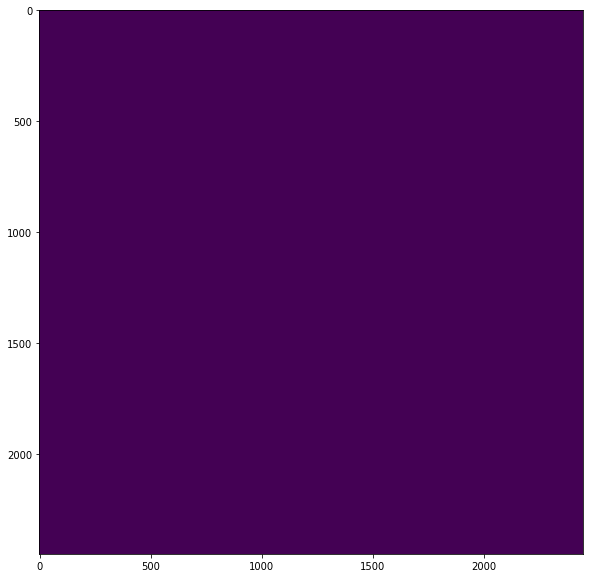

In [15]:
plt.imshow(pred)

In [16]:
np.unique(pred)

array([0])

NameError: name 'loss_dic' is not defined

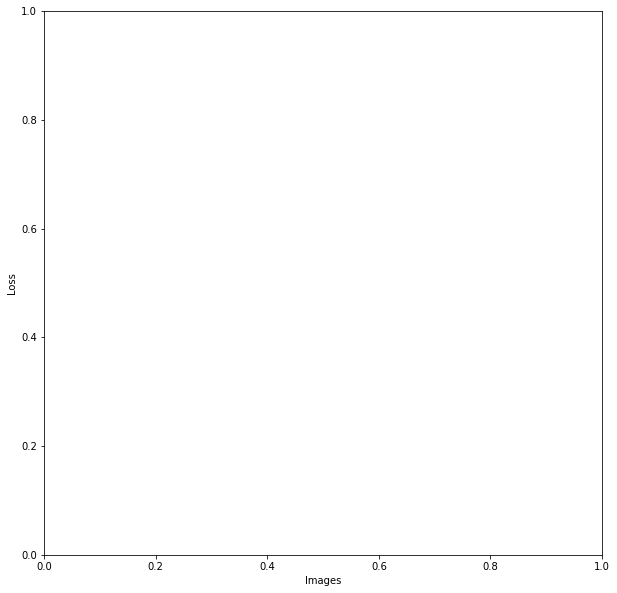

In [15]:
fig, ax = plt.subplots(1)
ax.set_ylabel('Loss')
ax.set_xlabel("Images")
for epoch, losses in loss_dic.items(): 
  x = [i * 30 for i in range(len(losses))]
  ax.plot(x, losses, label=f'Epoch: {epoch}')
ax.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


new_data_shape=2544.0


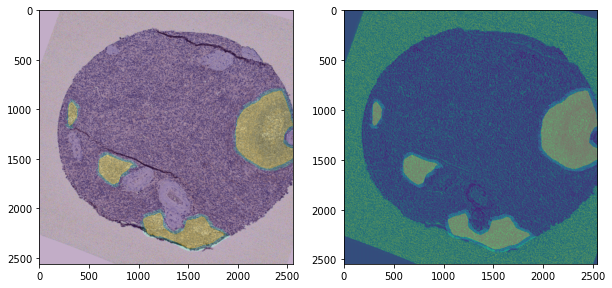

In [107]:
class metamodel():
  def __init__(self, model, depth):
    self.model = model
    self.depth = depth

  def predict(self, image, label):
    image = image.permute(2,0,1)
    image_patches, label_patches = cut_img(image, label, depth=self.depth)
    img_pred = []
    for i, patch in enumerate(DataLoader(image_patches)):
      patch = patch.float()
      pred = model(patch).squeeze().softmax(0).argmax(0)
      pred = pred.detach()
      img_pred.append(pred)
    img_pred = torch.stack(img_pred)
    img_pred = image_recon(img_pred)
    label = [label_patches[i] for i in range(label_patches.shape[0])]
    label = torch.stack(label)
    label = image_recon(label)
    return img_pred, label

depth = 4
model = UNet(num_classes=2, depth=depth, merge_mode='concat')
meta = metamodel(model, depth)
img, label = dataset[7]
image = img.permute(2,0,1)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(unnormalize(img.permute(2,0,1)).permute(1,2,0))
ax[0].imshow(label, alpha=0.3)

img_pred, label_new = meta.predict(img, label)
ax[1].imshow(img_pred)
ax[1].imshow(label_new, alpha=0.3)